# Norman analysis

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import rapids_singlecell as rsc
import numpy as np
import scanpy as sc
import pandas as pd
import scipy
import numpy as np
import tqdm
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.X = adata.layers["counts"].copy()
    del adata.layers
    gc.collect()
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'

In [5]:
models = [i for i in os.listdir("/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models") if i.startswith("norman_r")]
models_noninject = sorted([i for i in models if not i.endswith("_inject")])
models_noninject

['norman_r1_v4',
 'norman_r1_v8',
 'norman_r2_v1',
 'norman_r2_v2',
 'norman_r2_v3',
 'norman_r2_v5',
 'norman_r2_v6',
 'norman_r2_v7']

In [6]:
model_name = "norman_r2_v2"

In [7]:
model_name

'norman_r2_v2'

In [8]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    model_name
)
vae = tardis.MyModel.load(dir_path, adata=adata)
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v2/model.pt already          
         downloaded                                                                                                


CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/tmp/ipykernel_449498/1232802814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [9]:
color2prots = {"red": ["MAP2K3 + SLC38A2",
"ELMSAN1 + ctrl",
"MAP2K3 + ELMSAN1",
"MAP2K3 + MAP2K6",
"MAP2K6 + ELMSAN1",
"MAP2K6 + ctrl",
"ctrl + MAP2K6",
"KLF1 + MAP2K6",
"ctrl + ELMSAN1"],
"orange":["CEBPE + KLF1",
"KLF1 + BAK1",
"KLF1 + TGFBR2",
"KLF1 + MAP2K6",
"AHR + KLF1",
"KLF1 + ctrl",
"ctrl + KLF1"],
"blue":["IGDCC3 + ctrl",
"PRTG + ctrl",
"ETS2 + PRTG",
"TGFBR2 + PRTG",
"ETS2 + IGDCC3",
"MAPK1 + PRTG",
"IGDCC3 + MAPK1",
"TGFBR2 + IGDCC3",
"ctrl + IGDCC3"],
"sea green":["MAPK1 + TGFBR2",
"MAPK1 + ctrl",
"ctrl + ETS2",
"ETS2 + MAPK1",
"CEBPB + MAPK1",
"ctrl + MAPK1",],
"pink":["ctrl + COL2A1",
"COL2A1 + ctrl",
"COL1A1 + ctrl",
"KLF1 + COL2A1",],
"cami green":["FEV + CBFA2T3",
"FEV + ISL2",
"AHR + FEV",
"ctrl + FEV",
"FEV + ctrl"],
"green":["ctrl + SPI1",
"SPI1 + ctrl",
"CEBPE + SPI1",
"CEBPE + RUNX1T1",
"CEBPE + ctrl",
"KLF1 + CEBPA",
"FOSB + CEBPB",
"FOSB + CEBPE",
"ZC3HAV1 + CEBPA",
"ctrl + CEBPA",
"JUN + CEBPB",
"CEBPE + CEBPA",
"CEBPB + CEBPA",
"ctrl + CEBPB",
"CEBPE + CEBPB",
"CEBPB + ctrl",
"CEBPA + ctrl",
"ETS2 + CEBPE"],
"dark purple":["DUSP9 + SNAI1",
"ZBTB10 + SNAI1",
"FOXA1 + FOXL2",
"FOXA3 + ctrl",
"FOXA3 + FOXA1",
"FOXF1 + FOXL2",
"FOXA1 + HOXB9",
"FOXA3 + FOXF1",
"FOXA1 + FOXF1",
"ctrl + CEBPA",
"MIDN + ctrl",
"TP73 + ctrl",
"FOXA3 + FOXL2",
"FOXA3 + HOXB9",
"FOXL2 + MEIS1",
"FOXL2 + MEIS1",
"POU3F2 + FOXL2",
"HOXA13 + ctrl",
"LYL1 + IER5L",
"ctrl + HOXC13",
"HOXC13 + ctrl",
],
"yellow":["POU3F2 + CBFA2T3",
"ctrl + IKZF3",
"IKZF3 + ctrl",
"MAP2K6 + IKZF3",
"FOSB + IKZF3",
"ETS2 + IKZF3",
"MAP2K3 + IKZF3",
"MAPK1 + IKZF3"],
"pistachio":["DUSP9 + PRTG",
"DUSP9 + IGDCC3",
"DUSP9 + ctrl",
"DUSP9 + ETS2",
"DUSP9 + KLF1",
"DUSP9 + IGDCC3",],
"dark blue":["RHOXF2 + ZBTB25",
"DUSP9 + IGDCC3",
"RHOXF2 + SET",
"SET + CEBPE",
"ctrl + SET",
"SET + ctrl",
"IRF1 + SET"],
"dark pink":["ATL1 + ctrl",
"SAMD1 + UBASH3B",
"CBL + UBASH3B",
"PTPN1 + ctrl",
"UBASH3B + PTPN9",
"SAMD1 + PTPN12",
"BPGM + SAMD1",
"CNN1 + UBASH3A",
"UBASH3B + CNN1",
"UBASH3B + ZBTB25",
"CBL + CNN1",
"PTPN12 + UBASH3A",
"PTPN12 + PTPN9",
"PTPN12 + ZBTB25",
"CBL + PTPN12",
"UBASH3B + PTPN12"],
"purple": ["CDKN1C + CDKN1B",
"ctrl + CDKN1A",
"CDKN1B + CDKN1A",
"CDKN1C + CDKN1A",
"CDKN1B + ctrl",
"CDKN1A + ctrl",
"CDKN1B + CDKN1A",
"CDKN1C + ctrl",
] 
}

colors = {"sea green": "#60bcb4",
"orange": "#db8b45",
"red":"#cf5f4d",
"blue":"#4cbbdc",
"pink": "#c1599f",
"green": "#c1599f",
"cami green": "#66c287",
"yellow": "#ddc44c",
"dark purple":"#6567ad",
"dark pink": "#d54e7f",
"pistachio": "#69c751",
"purple": "#7d57a2",
"dark blue": "#547cc4",
}

adata.obs["annotation"] = np.nan
for color, items in color2prots.items():
    for item in items:
        item_ = item.replace(" ", "")
        if not np.sum(adata.obs["condition"] == item_) > 0:
            print(item_)
        adata.obs["annotation"][adata.obs["condition"] == item_] = color

/tmp/ipykernel_449498/2804703637.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["annotation"][adata.obs["condition"] == item_] = color


In [10]:
from tardis._disentanglementmanager import DisentanglementManager as DM

sublatent = DM.configurations.get_by_obs_key("condition").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
# latent = latent[vae.train_indices].copy()
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(latent)
rsc.tl.umap(latent)
rsc.utils.anndata_to_CPU(latent)

In [11]:
if False:
    def generate_random_colors(num_colors):
        return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
    unique_cell_types = latent.obs["condition"].unique()
    random_colors = generate_random_colors(len(unique_cell_types))
    color_map = dict(zip(unique_cell_types, random_colors))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(20, 20))
        sc.pl.umap(
            latent, 
            color=["condition"], 
            ncols=1,
            size=8,
            frameon=False,
            palette=color_map,
            legend_loc="on data",
            legend_fontsize=6,
            legend_fontweight='bold',
            ax=plt.gca(),
        show=False
        )
    plt.show()

In [12]:
if False:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            latent, 
            ncols=2,
            color=["annotation", "validation"], 
        )

In [201]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labs = latent.obs["annotation"].to_numpy().copy()
non_nan_indices = ~pd.isnull(labs)
labs[non_nan_indices] = label_encoder.fit_transform(labs[non_nan_indices])
labs = ["NA" if pd.isnull(i) else str(i+1) for i in labs]
latent.obs["Gene Programs"] = labs

In [202]:
latent.obs["Gene Programs"] = latent.obs["Gene Programs"].to_numpy()
latent.obs.loc[latent.obs["condition"] == "ctrl", "Gene Programs"] = "Unperturbed"

In [218]:
_a = sorted(latent.uns.keys())
for _i in _a:
    if _i.endswith("_colors"):
        del latent.uns[_i]

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


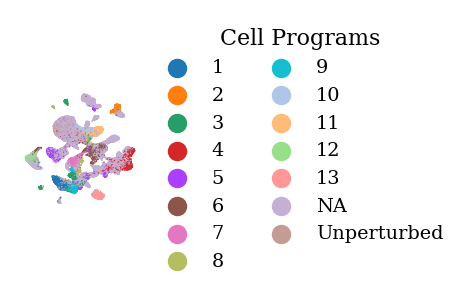

In [219]:
figsize = (1,1)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

fig = sc.pl.umap(
    latent,
    color="Gene Programs",
    ncols=2,
    frameon=False,
    legend_fontsize="x-small",
    show=False,
    ax=plt.gca(),
    # palette=sns.color_palette("colorblind", 15),
    title="",
    # legend_loc="on data",
    # legend_fontweight="semibold",
    # legend_fontoutline=2,
    # add_outline=True,
    # return_fig=True
);
plt.gca().legend_.set_title("Cell Programs", prop={'size':8});

# plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig6_umap_genegroups_{model_name}.pdf"), format="pdf")

In [232]:
colors_custom = [
    "#FFE119",  # Yellow
    "#E6194B",  # Red
    "#3CB44B",  # Green
    "#4363D8",  # Blue
    "#F58231",  # Orange
    "#911EB4",  # Purple
    "#46F0F0",  # Cyan
    "#F032E6",  # Magenta
    "#FABEBE",  # Pink
    "#008080",  # Teal
    "#E6BEFF",  # Lavender
    "#9A6324",  # Brown
    "#FFD700",  # Gold (instead of Lime)
]


In [233]:
for ind, c in enumerate(colors_custom):
    latent.uns['Gene Programs_colors'][ind] = c
latent.uns['Gene Programs_colors'][-2] = "#d3d3d340"
latent.uns['Gene Programs_colors'][-1] = "#adadad"

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


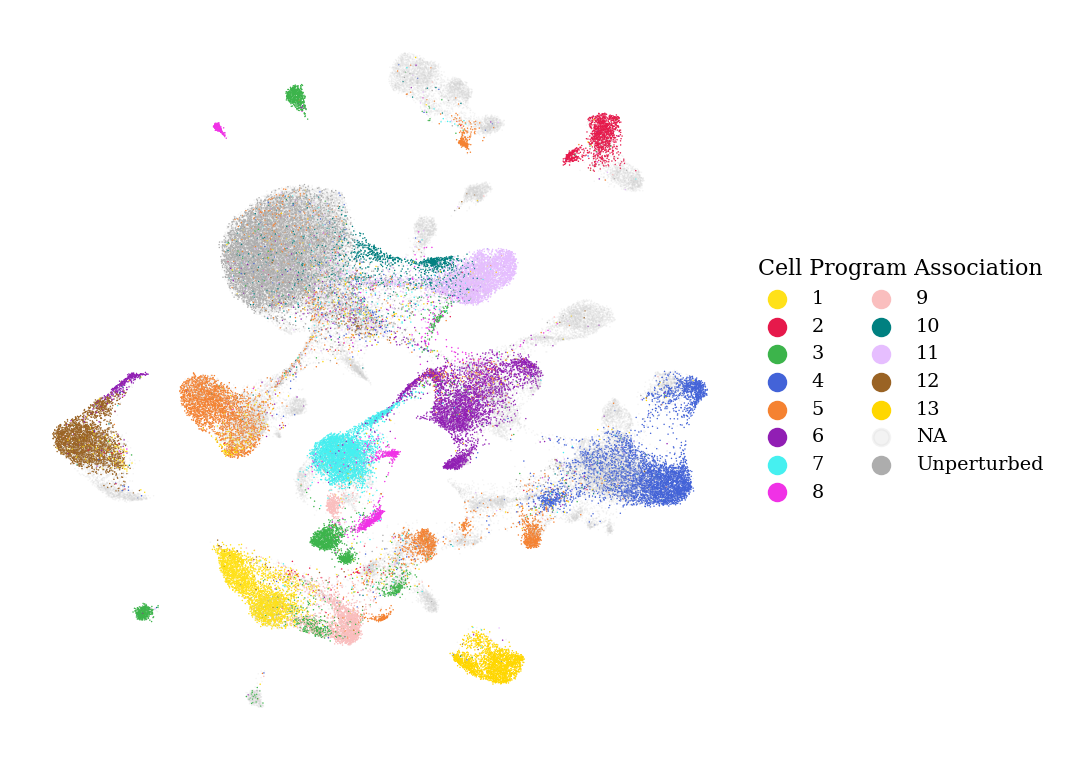

In [235]:
figsize = (6, 6)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

fig = sc.pl.umap(
    latent,
    color="Gene Programs",
    ncols=2,
    frameon=False,
    legend_fontsize="x-small",
    show=False,
    ax=plt.gca(),
    title="",
    # legend_loc="on data",
    # legend_fontweight="semibold",
    # legend_fontoutline=2,
    # add_outline=True,
    # return_fig=True
)
plt.gca().legend_.set_title("Cell Program Association", prop={'size':8})

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig6_umap_genegroups_{model_name}.pdf"), format="pdf")

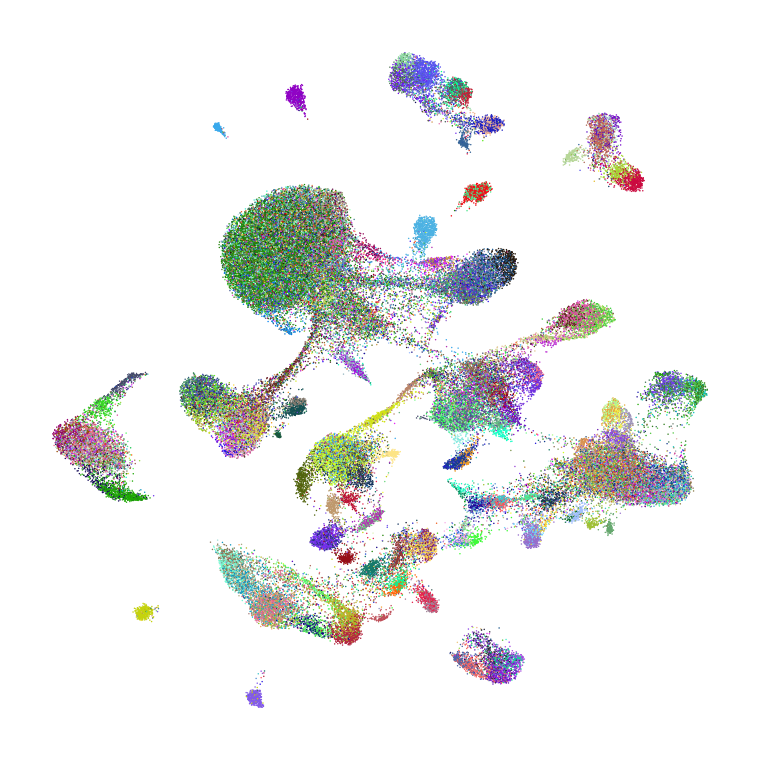

In [245]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = latent.obs["condition"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    figsize = (6, 6)
    fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
    fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)
    
    sc.pl.umap(
        latent, 
        color=["condition"], 
        ncols=1,
        frameon=False,
        palette=color_map,
        legend_loc=None,
        ax=plt.gca(),
        title="",
        show=False
    )
plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig6_umap_conditions_{model_name}_9.pdf"), format="pdf")

In [329]:
def calculate_centroids_iqr(data, labels, multiplier=1.5):
    """
    Calculate centroids excluding outliers based on IQR.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
        multiplier (float): Multiplier for the IQR to define the confidence interval.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition.
    """
    unique_conditions = np.unique(labels)
    mean_centroids = dict()

    for condition in tqdm.tqdm(unique_conditions):
        condition_data = data[labels == condition]
        Q1 = np.percentile(condition_data, 25, axis=0)
        Q3 = np.percentile(condition_data, 75, axis=0)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # Filtering out the outliers
        is_not_outlier = np.all((condition_data >= lower_bound) & (condition_data <= upper_bound), axis=1)
        filtered_data = condition_data[is_not_outlier]

        # Calculate the mean of the filtered data
        mean_centroids[condition] = np.mean(filtered_data, axis=0)

    return mean_centroids


In [330]:
def calculate_centroids_median(data, labels):
    """
    Calculate centroids using the median to be robust against outliers.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition based on the median.
    """
    unique_conditions = np.unique(labels)
    median_centroids = dict()

    for condition in tqdm.tqdm(unique_conditions):
        condition_data = data[labels == condition]
        # Computing the median across rows for this condition
        median_centroids[condition] = np.median(condition_data, axis=0)

    return median_centroids


In [331]:
labels = latent.obs["condition"].to_numpy().flatten()
centroids_iqr = calculate_centroids_iqr(latent.X, labels=labels, multiplier = 1.0)
centroids_median = calculate_centroids_median(latent.X, labels=labels)

the_same = dict()
singles = set()
doubles = set()
singles_dict = dict()

for c in latent.obs["condition"].unique():
    if "+" not in c:
        assert c == "ctrl"
        k = ("ctrl", "ctrl")
    else:
        assert c.count("+") == 1
        k = tuple(sorted(c.split("+")))
            
    if k not in the_same:
        the_same[k] = []
    the_same[k].append(c)


    if "ctrl" in k:
        singles.add(k)
        i = list(k).index("ctrl")
        l = k[0] if i==1 else k[1]
        if l not in singles_dict:
            singles_dict[l] = []
        singles_dict[l].append(k)
    else:
        doubles.add(k)

def ctrl_remover_single(asd):
    assert "ctrl" in asd
    k = tuple(sorted(asd.split("+")))
    i = list(k).index("ctrl")
    l = k[0] if i==1 else k[1]
    return l

combinations = []
for d1, d2 in doubles:
    css = the_same[(d1, d2)]
    d1s = singles_dict[d1]
    d2s = singles_dict[d2]
    d1ss = {j for i in d1s for j in the_same[i]}
    d2ss = {j for i in d2s for j in the_same[i]}
    assert len(css) == 1
    css = css[0]
    combinations.append([css, list(d1ss), list(d2ss)])    

centroids = centroids_iqr

vectors = dict()
for combin, perturb1, perturb2 in combinations:
    for perturb in [perturb1, perturb2]:
        for pertur in perturb:
            pertur_vector = centroids[pertur] - centroids["ctrl"]
            vectors[pertur] = pertur_vector
    combin_vector = centroids[combin] - centroids["ctrl"]
    vectors[combin] = combin_vector
for s in singles:
    for ss in the_same[s]:
        if ss not in vectors:
            vectors[ss] = centroids[ss] - centroids["ctrl"]

sames = set()
for i in the_same:
    if len(the_same[i]) > 1:
        for j in the_same[i]:
            sames.add(j)

singles_set = set()
for s in singles:
    for ss in the_same[s]:
        singles_set.add(ss)
singles_set = list(singles_set)

singles_pairwise = []
for ind, ss1 in enumerate(singles_set):
    if ss1 == "ctrl":
        continue
    for ss2 in singles_set[ind:]:
        if ss2 == "ctrl":
            continue
        if ctrl_remover_single(ss1) != ctrl_remover_single(ss2):
            singles_pairwise.append(scipy.stats.wasserstein_distance(vectors[ss1], vectors[ss2]))

len(singles_pairwise), len(singles_set)

distance_singles_same = []
for k, v in the_same.items():
    if len(v) > 1:
        assert len(v) == 2
        ss1, ss2 = v
        distance_singles_same.append(scipy.stats.wasserstein_distance(vectors[ss1], vectors[ss2]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 670.11it/s]


In [332]:
np.median(singles_pairwise), np.median(distance_singles_same)

(0.9945728772630295, 0.04685741166273754)

In [333]:
labels = len(singles_pairwise) * ["Different"] + len(distance_singles_same) * ["Same"]
values = singles_pairwise + distance_singles_same
df = pd.DataFrame([values, labels], index=["values", "labels"]).T

/tmp/ipykernel_1261601/3348793711.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x="labels", y="values", palette=["gray", "silver"], err_kws={'linewidth': 1})


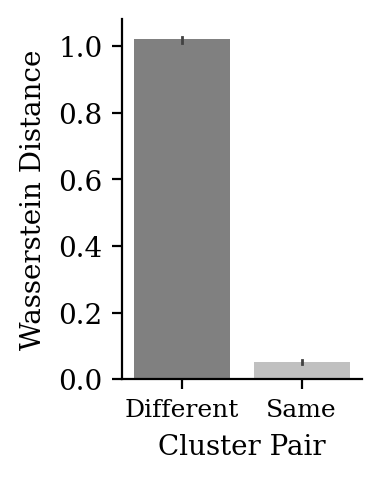

In [334]:
figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

sns.barplot(df, x="labels", y="values", palette=["gray", "silver"], err_kws={'linewidth': 1})

plt.ylabel("Wasserstein Distance")
plt.xlabel("Cluster Pair")
plt.xticks(fontsize=9)
sns.despine()

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig6_sames_{model_name}.pdf"), format="pdf")

In [54]:
combination_distance = []
for combin, perturb1, perturb2 in combinations:
    true_vector = vectors[combin]
    prediction_vector = vectors[perturb1[0]] + vectors[perturb2[0]]
    combination_distance.append(scipy.stats.wasserstein_distance(true_vector, prediction_vector))

In [55]:
np.sum(np.array(combination_distance)<2)/ len(combination_distance), np.sum(np.array(singles_pairwise)<2)/ len(singles_pairwise)

(0.9541984732824428, 0.9548516930615102)

<Axes: ylabel='Density'>

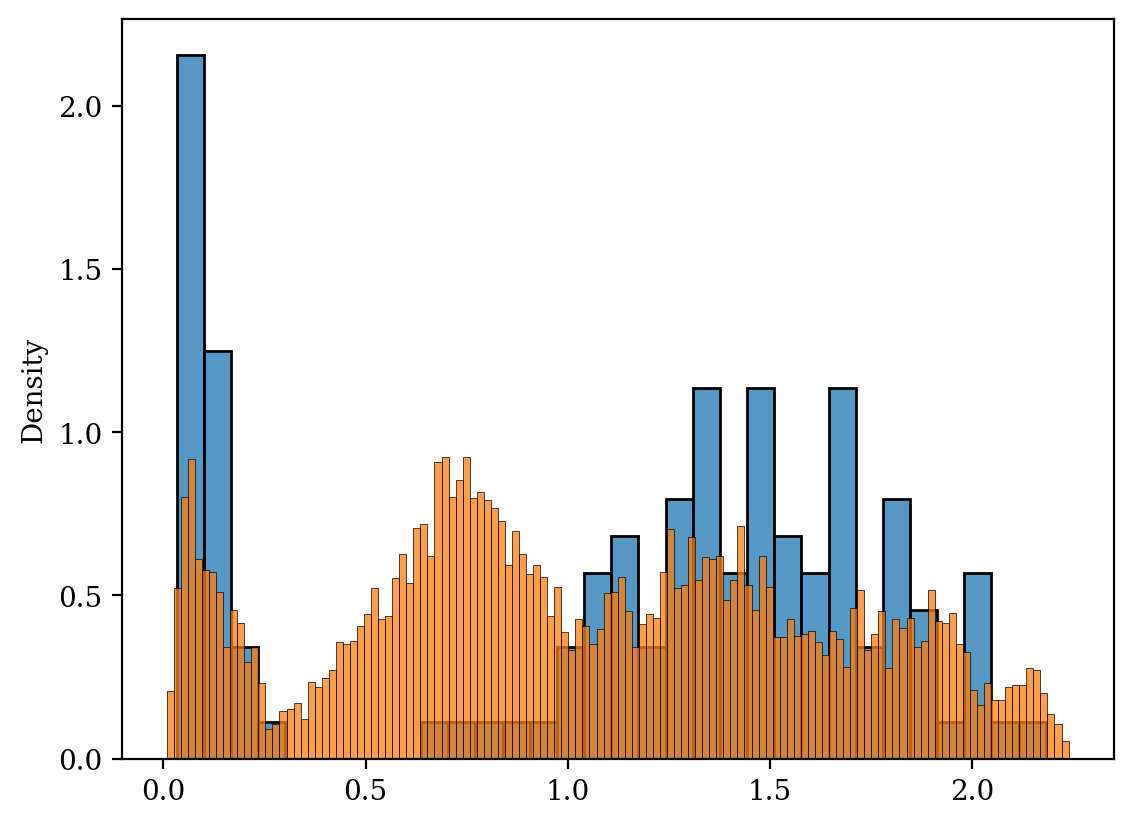

In [56]:
sns.histplot(combination_distance, bins=32, stat="density")
sns.histplot(singles_pairwise, bins=128, stat="density")


<Axes: ylabel='Density'>

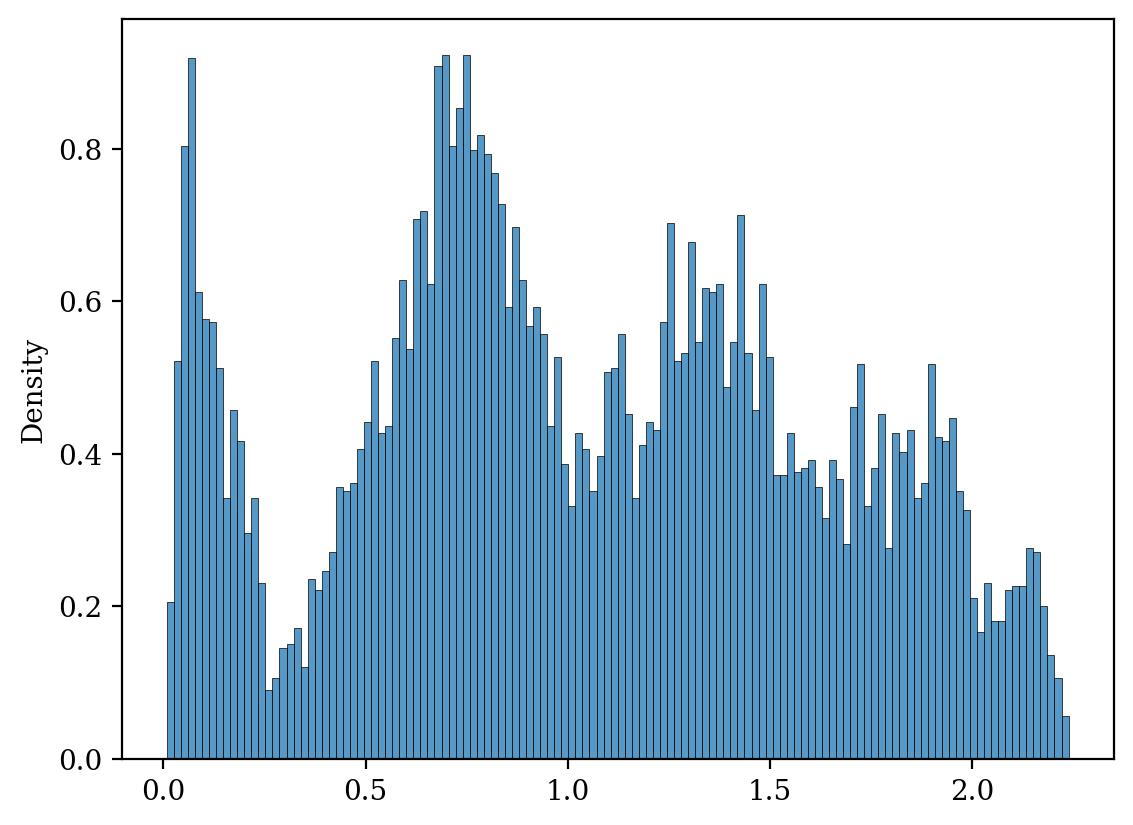

In [57]:
sns.histplot(singles_pairwise, bins=128, stat="density")

In [1189]:
baseline_adata = ad.read_h5ad("/home/icb/kemal.inecik/lustre_workspace/downloaded_data/norman_2019.h5ad")

In [1190]:
baseline_adata.obs

guide_identity  read_count  \
index                                                                    
AAACCTGAGAAGAAGC-1    NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0        1252   
AAACCTGAGGCATGTG-1      TSC22D1_NegCtrl0__TSC22D1_NegCtrl0        2151   
AAACCTGAGGCCCTTG-1                KLF1_MAP2K6__KLF1_MAP2K6        1037   
AAACCTGCACGAAGCA-1  NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0         958   
AAACCTGCAGACGTAG-1            CEBPE_RUNX1T1__CEBPE_RUNX1T1         244   
...                                                    ...         ...   
TTTGTCATCAGTACGT-8          FOXA3_NegCtrl0__FOXA3_NegCtrl0        2068   
TTTGTCATCCACTCCA-8          CELF2_NegCtrl0__CELF2_NegCtrl0         829   
TTTGTCATCCCAACGG-8        BCORL1_NegCtrl0__BCORL1_NegCtrl0         136   
TTTGTCATCCTCCTAG-8            ZBTB10_PTPN12__ZBTB10_PTPN12        1254   
TTTGTCATCTGGCGAC-8        MAP4K3_NegCtrl0__MAP4K3_NegCtrl0        1226   

                    UMI_count   coverage  gemgroup  good_coverage  \
index                                                               
AAACCTGAGAAGAAGC-1         67  18.686567         1           True   
AAACCTGAGGCATGTG-1        104  20.682692         1           True   
AAACCTGAGGCCCTTG-1         59  17.576271         1           True   
AAACCTGCACGAAGCA-1         39  24.564103         1           True   
AAACCTGCAGACGTAG-1         14  17.428571         1           True   
...                       ...        ...       ...            ...   
TTTGTCATCAGTACGT-8         95  21.768421         8           True   
TTTGTCATCCACTCCA-8         33  25.121212         8           True   
TTTGTCATCCCAACGG-8          9  15.111111         8           True   
TTTGTCATCCTCCTAG-8         59  21.254237         8           True   
TTTGTCATCTGGCGAC-8         59  20.779661         8           True   

                    number_of_cells  guide_AHR  guide_ARID1A  guide_ARRDC3  \
index                                                                        
AAACCTGAGAAGAAGC-1                2          0             0             0   
AAACCTGAGGCATGTG-1                1          0             0             0   
AAACCTGAGGCCCTTG-1                1          0             0             0   
AAACCTGCACGAAGCA-1                1          0             0             0   
AAACCTGCAGACGTAG-1                1          0             0             0   
...                             ...        ...           ...           ...   
TTTGTCATCAGTACGT-8                1          0             0             0   
TTTGTCATCCACTCCA-8                1          0             0             0   
TTTGTCATCCCAACGG-8                1          0             0             0   
TTTGTCATCCTCCTAG-8                3          0             0             0   
TTTGTCATCTGGCGAC-8                1          0             0             0   

                    ...  n_genes  n_genes_by_counts  total_counts  \
index               ...                                             
AAACCTGAGAAGAAGC-1  ...     4108               4108       19413.0   
AAACCTGAGGCATGTG-1  ...     3142               3142       13474.0   
AAACCTGAGGCCCTTG-1  ...     4229               4229       23228.0   
AAACCTGCACGAAGCA-1  ...     2114               2114        6842.0   
AAACCTGCAGACGTAG-1  ...     2753               2753        9130.0   
...                 ...      ...                ...           ...   
TTTGTCATCAGTACGT-8  ...     3305               3305       14727.0   
TTTGTCATCCACTCCA-8  ...     2842               2842        9750.0   
TTTGTCATCCCAACGG-8  ...     2824               2824        8670.0   
TTTGTCATCCTCCTAG-8  ...     5180               5179       29247.0   
TTTGTCATCTGGCGAC-8  ...     3058               3058       12514.0   

                    total_counts_mt  pct_counts_mt  leiden  perturbation_name  \
index                                                                           
AAACCTGAGAAGAAGC-1           1327.0       6.835625      10            control   
AAACCTGAGGCATGTG-1         

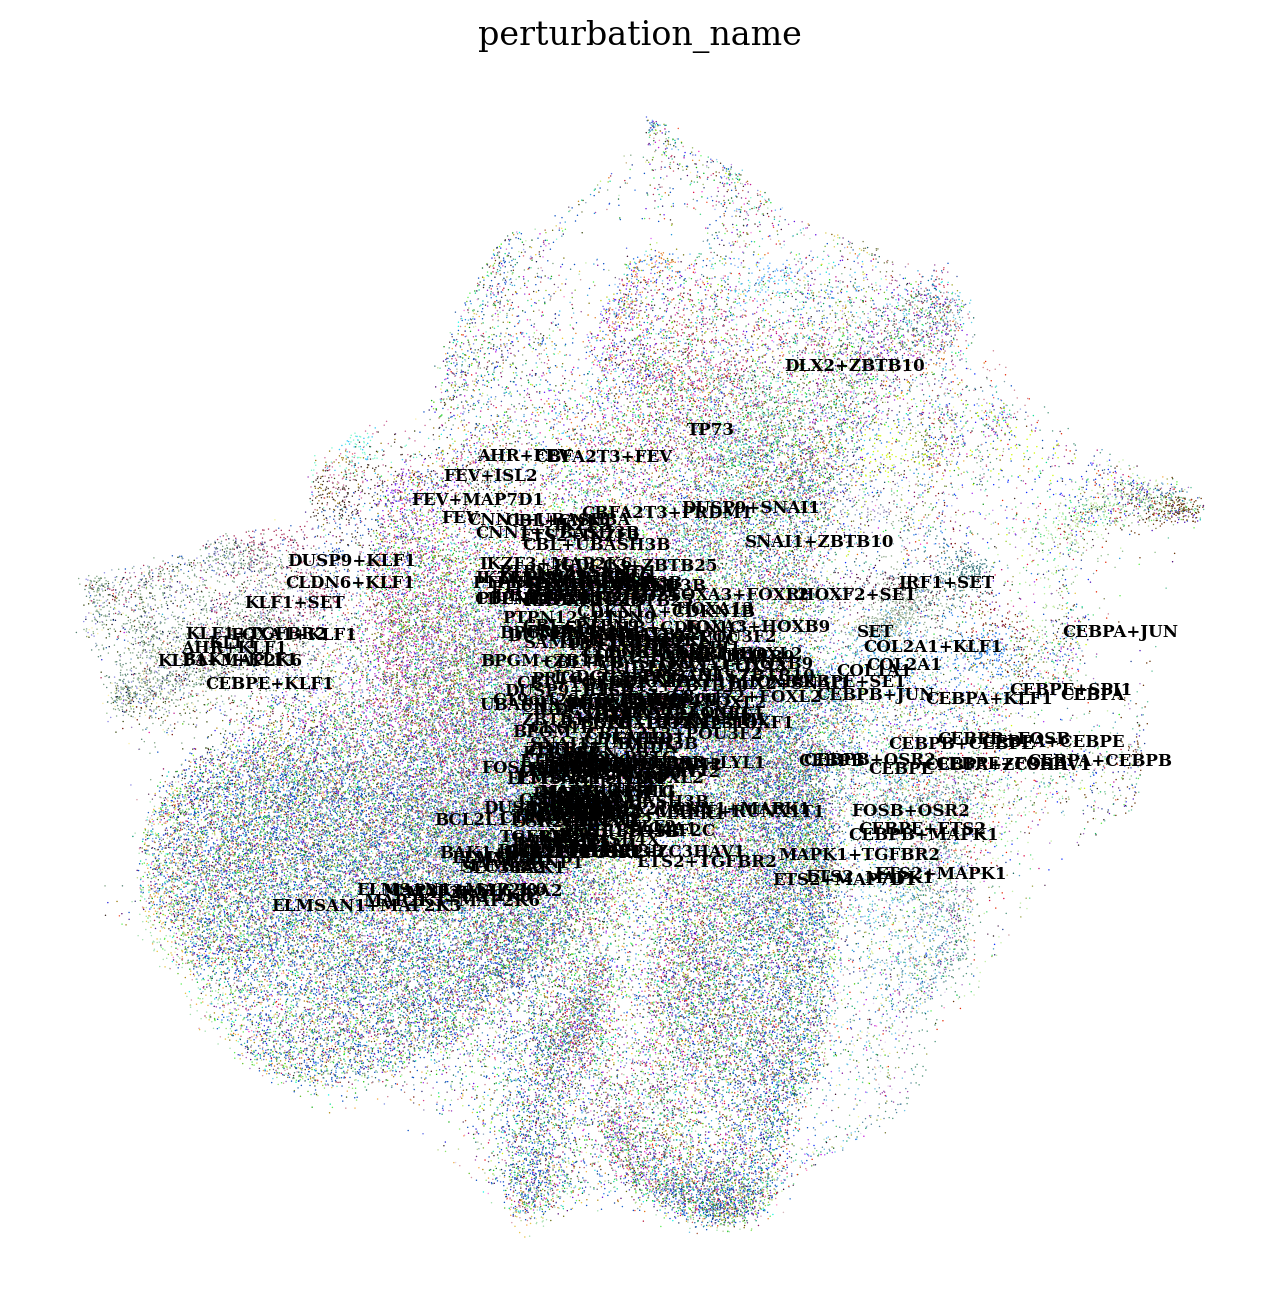

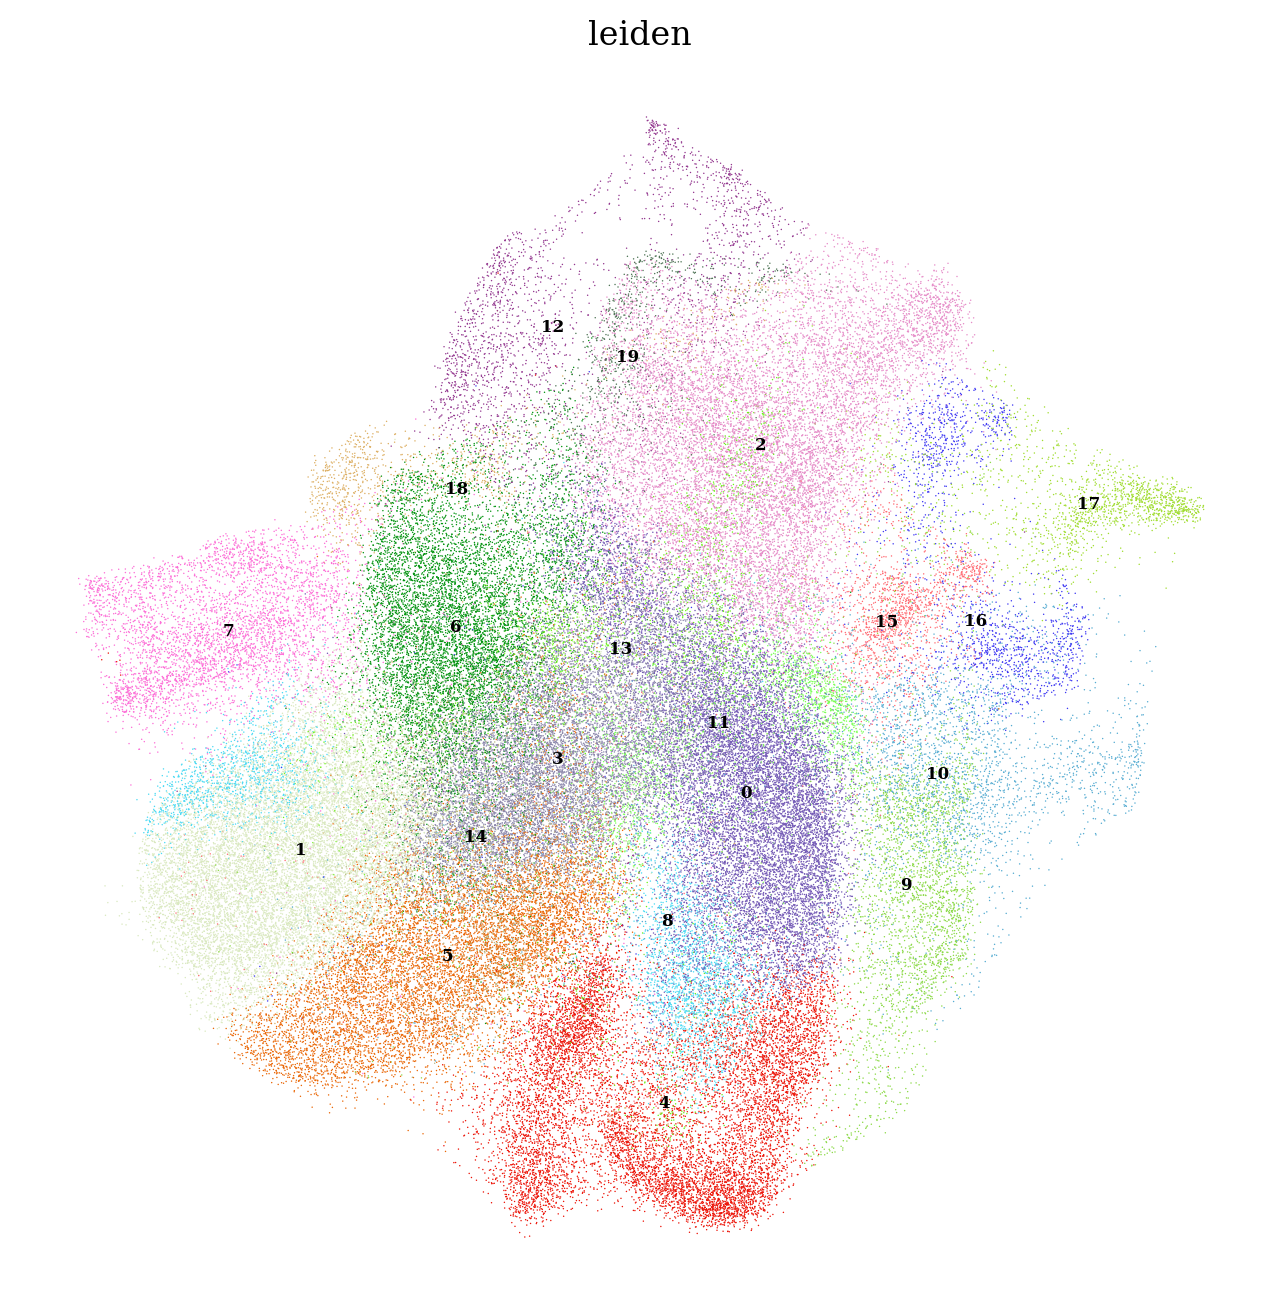

In [396]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = baseline_adata.obs["perturbation_name"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 8))
    sc.pl.umap(
        baseline_adata, 
        color=["perturbation_name"], 
        ncols=1,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

unique_cell_types = baseline_adata.obs["leiden"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 8))
    sc.pl.umap(
        baseline_adata, 
        color=["leiden"], 
        ncols=1,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

In [48]:
# resolution = 1.12345
# rsc.tl.leiden(latent, resolution=np.round(resolution, 3), key_added="leiden_" + format(resolution, ".3f"))